In [1]:
# Importing Libraries
import os
import cv2
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt

In [2]:
# get the current directory location
currentWorkingDirectory = os.getcwd()


In [3]:
# adding all category to this list
categories = ["crusier", "off road bikes", "scooter"]

In [4]:
# getting data ready for training and testing

X = []  # used for storing input values
y = []  # used for storing output value

# for each category
for categoryLabel, category in enumerate(categories):
    
    # change current working directory to particular category folder
    os.chdir(f"{currentWorkingDirectory}/dataset/preprocessedData/{category}")
    
    # for each image
    for img in os.listdir():
        
        # read image in gray scale
        image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        
        # convert (48 * 48) image shape to (2304, 1) shape using ravel function
        image = image.ravel()
        
        # standard scaling between 0 to 1 by dividing 255
        image = image / 255
        
        X.append(image)
        
        y.append(categoryLabel)
        
# joining both input and output data
data = list(zip(X, y))

random.shuffle(data)  # shuffle the data to get different datas

totalSize = len(data)
trainSize = int(totalSize * 0.8)

X, y = zip(*data)  # convert back to input and output data

# split the data into train and test data
X_train, y_train = X[:trainSize], y[:trainSize]
X_test, y_test = X[trainSize:], y[trainSize:]

# convert it into numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# finally change directory to current working directory
os.chdir(currentWorkingDirectory)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")


X_train shape: (52, 2304)
y_train shape: (52,)
X_test shape: (13, 2304)
y_test.shape: (13,)


Category: off road bikes


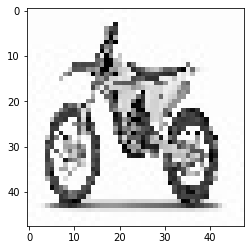

In [6]:
# displaying a random image with its category label
i = random.randint(0, 16)  # random index 

sample = X_train[i].reshape((48, 48))  # reshape the data to 2-dimention

print(f"Category: {categories[int(y_train[i])]}")

plt.imshow(sample, cmap='gray')

In [7]:
# calculating distance between two images
# Euclidean distance

def getDistance(x1, x2):
    total = 0
    for i in range(len(x1)):
        total += (x1[i] - x2[i]) ** 2
    return np.sqrt(total)

In [8]:
# calculating centroids using kmeans

def kmeans(X, noOfCentroids, maxIterations=100):
  
    centroids = X[np.random.choice(range(len(X)), noOfCentroids, replace=False)]

    converged = False
    
    currentIteration = 1

    # for each iteration
    while((not converged) and (currentIteration <= maxIterations)):

        clusterList = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point 
            
            distancesList = []
            
            for centroid in centroids:
                distancesList.append(getDistance(centroid, x))
                
            clusterList[int(np.argmin(distancesList))].append(x)

        clusterList = list((filter(None, clusterList)))

        prevCentroids = centroids.copy()

        centroids = []

        for j in range(len(clusterList)):
            centroids.append(np.mean(clusterList[j], axis=0))

        difference = np.abs(np.sum(prevCentroids) - np.sum(centroids))

        print(f"K-Means difference for {currentIteration} iterations: {int(difference)}")
        converged = (difference == 0)

        currentIteration += 1

    return np.array(centroids)

In [9]:
class RBF:

    def __init__(self, X_train, y_train, X_test, y_test, numOfClasses, numOfClusters):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test

        self.numOfClasses = numOfClasses
        self.numOfClusters = numOfClusters

        
    def convert_to_one_hot(self, x):
        arr = np.zeros((len(x), self.numOfClasses))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    
    def rbf(self, x, centroid, s):
        distance = getDistance(x, centroid)
        return 1 / np.exp(-distance / s ** 2)

    
    def calculateG(self, X):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(self.centroids, self.std_list)])
        return np.array(RBF_list)


    def fit(self):

        # calculate centroids
        self.centroids = kmeans(self.X_train, self.numOfClusters)

        # calculating standard deviation
        dMax = np.max([getDistance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
        self.std_list = np.repeat(dMax / np.sqrt(2 * self.numOfClusters), self.numOfClusters)
        
        # training part
        G = self.calculateG(self.X_train)
    
        GTG = np.dot(G.T, G)
        
        GTG_inv = np.linalg.inv(GTG)
        
        fac = np.dot(GTG_inv ,G.T)
        
        self.weights = np.dot(fac, self.convert_to_one_hot(self.y_train))
        
        # testing part
        RBF_list_tst = self.calculateG(self.X_test)

        self.pred_ty = np.dot(RBF_list_tst, self.weights)

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.y_test

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))


In [10]:
rbfClassifier = RBF(X_train, y_train, X_test, y_test, len(categories), 6)
rbfClassifier.fit()



K-Means difference for 1 iterations: 142
K-Means difference for 2 iterations: 0
K-Means difference for 3 iterations: 215
K-Means difference for 4 iterations: 439
K-Means difference for 5 iterations: 5
K-Means difference for 6 iterations: 0
Accuracy:  0.46153846153846156


In [11]:
rbfClassifier.weights


array([[-2.16571428,  4.423356  , -2.05960786],
       [-1.1847379 , -0.06380731,  1.56075395],
       [ 3.79287611, -2.91697628, -0.75430714],
       [ 1.64153341,  1.71509518, -3.39743031],
       [ 2.48205968,  2.68284372, -5.07534659],
       [-4.30556622, -5.62294565,  9.93068297]])

In [12]:
rbfClassifier.centroids

array([[0.99803922, 0.99901961, 0.99901961, ..., 0.99656863, 0.99607843,
        0.99558824],
       [0.09673203, 0.10718954, 0.10849673, ..., 0.27581699, 0.35294118,
        0.32941176],
       [0.99607843, 0.99411765, 0.99705882, ..., 0.94901961, 0.96568627,
        0.98529412],
       [1.        , 1.        , 1.        , ..., 0.99607843, 0.99477124,
        0.99869281],
       [0.99387255, 0.98602941, 0.99387255, ..., 0.98235294, 0.99338235,
        0.98529412],
       [0.98126362, 0.9832244 , 0.98518519, ..., 0.98518519, 0.9832244 ,
        0.98126362]])

In [13]:
rbfClassifier.std_list


array([7.33890274, 7.33890274, 7.33890274, 7.33890274, 7.33890274,
       7.33890274])